In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import camb
from tqdm import tqdm
import healpy as hp
import pickle

In [8]:
observed_parameters = [0.676, 0.0220, 0.122, 3.085, 0.964]

def sim(params):
    # Create a set of cosmological parameters
    pars = camb.CAMBparams()
    H0 = params[0] * 100
    As = 1e-10*np.exp(params[3])
    pars.set_cosmology(H0=H0, ombh2=params[1], omch2=params[2])
    pars.InitPower.set_params(As=As, ns=params[4])
    pars.set_for_lmax(2500, lens_potential_accuracy=0)

    # Get the results from CAMB
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
    total = powers['total']
    cl = total[:, 0]
    return cl[2:2500]

observed_dataset = sim(observed_parameters)

In [9]:
def finite_derivative_calc_update(fiducial_vals, size):
    derivatives = []
    for i in tqdm(range(5)):
        step = size[i]
        parr = fiducial_vals.copy()
        parr[i] = fiducial_vals[i] + step
        parr2 = fiducial_vals.copy()
        parr2[i] = fiducial_vals[i] - step
        cl1 = sim(parr)
        cl2 = sim(parr2)
        derivative = (cl1 - cl2)/(2*step)
        derivatives.append(derivative.tolist())
    return derivatives

fiducial_values = [0.674,  0.0224,  0.120, 3.08, 0.965]
finite_param_steps = [0.0025, 0.0002, 0.0005, 0.0001, 0.001]
fiducial_dls = sim(fiducial_values)
finite_derivative = finite_derivative_calc_update(fiducial_values, finite_param_steps)

100%|██████████| 5/5 [00:17<00:00,  3.52s/it]


In [10]:
ls = np.arange(2510)[2:2500]
fac=ls*(ls+1)/(2*np.pi)
fiducial_cls =  fiducial_dls/fac


Text(0.5, 1.0, 'As = 1e-30')

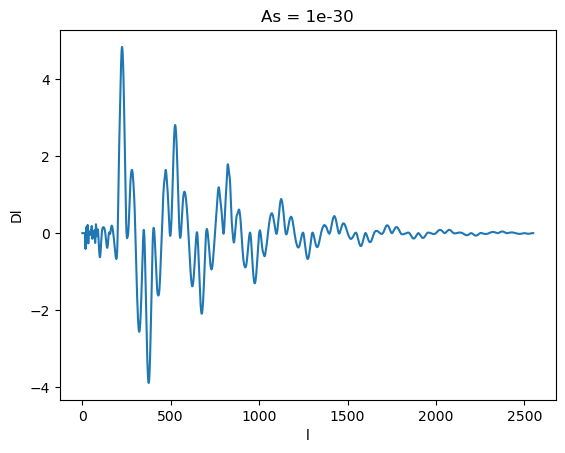

In [59]:
import camb
from camb import model, initialpower

# Set up a set of cosmological parameters with a very low primordial power spectrum amplitude
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(As=1e-20, ns=0.965)  # Set As to an extremely low value
pars.set_for_lmax(2500, lens_potential_accuracy=0)

# Calculate the results for these parameters
results = camb.get_results(pars)

# Get the total CMB power spectra, here 'tot' includes temperature, E and B polarizations, and lensing potential
powers = results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=True)
# powers is now an array with the shape (ell_max+1, 4) where columns are [TT, EE, BB, TE] respectively

# For example, to access the "almost empty" TT power spectrum:
TT_power_spectrum = powers['total'][:,0]

# If you need to convert to D_ell (ell*(ell+1)/2pi * C_ell), which is commonly plotted:
import numpy as np
ell = np.arange(len(TT_power_spectrum))
D_ell_TT = ell * (ell + 1) / (2 * np.pi) * TT_power_spectrum

plt.plot(D_ell_TT)
plt.xlabel('l')
plt.ylabel('Dl')
plt.title('As = 1e-30')

Text(0.5, 1.0, 'As = 1e-30')

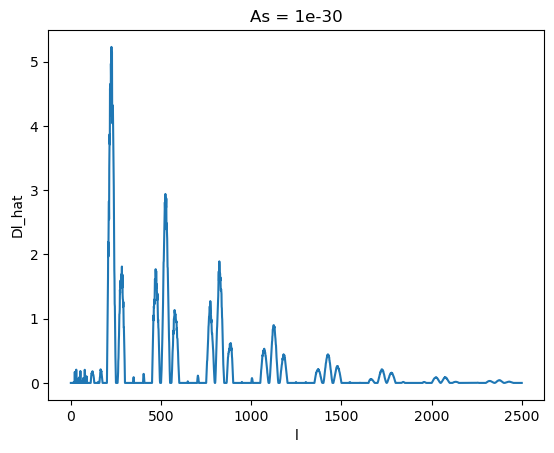

In [60]:
nside = 1024
cmb_map = hp.sphtfunc.synfast(D_ell_TT, nside=nside)
cl_hat = hp.sphtfunc.anafast(cmb_map)
plt.plot(cl_hat[:2500])
plt.xlabel('l')
plt.ylabel('Dl_hat')
plt.title('As = 1e-30')

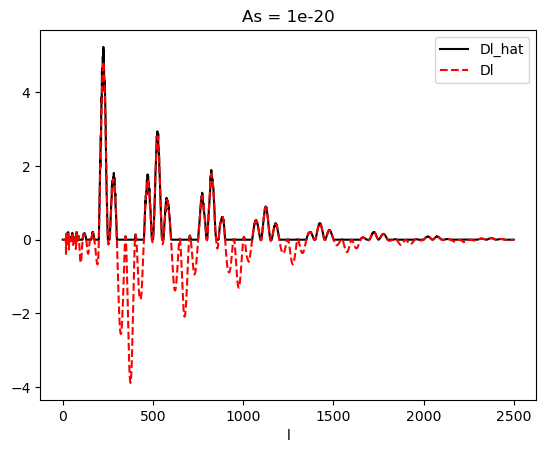

In [61]:
plt.plot(cl_hat[:2500], label = 'Dl_hat', color = 'black')
plt.plot(D_ell_TT[:2500],'--', label = 'Dl', color = 'red')
plt.xlabel('l')
plt.title('As = 1e-20')
plt.legend()

In [63]:
path='compression_vectors/output/LambdaCDM/'
TT2018=CosMOPED(path, year=2018, spectra='TT', use_low_ell_bins=False)
compression_vector_dict, compressed_data_dict = TT2018.read_compression_vectors_and_compressed_data(path)
compress_vec_h = compression_vector_dict['h']
compress_vec_ombh2 = compression_vector_dict['omega_b']
compress_vec_omch2 = compression_vector_dict['omega_cdm']
compress_vec_As = compression_vector_dict['A_s']
compress_vec_ns = compression_vector_dict['n_s']
def sim(params):
    # Create a set of cosmological parameters
    pars = camb.CAMBparams()
    H0 = params[0] * 100
    As = 1e-10*np.exp(params[3])
    pars.set_cosmology(H0=H0, ombh2=params[1], omch2=params[2])
    pars.InitPower.set_params(As=As, ns=params[4])
    pars.set_for_lmax(2500, lens_potential_accuracy=0)

    # Get the results from CAMB
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
    total = powers['total']
    dltt = total[:, 0][2:2509]
    ells = np.arange(2510)[2:2509]
    return dltt, ells

def compress(dltt, ells):
    fac = fac=ells*(ells+1)/(2*np.pi)
    cltt = dltt/fac
    return [compress_vec_h.dot(cltt), compress_vec_ombh2.dot(cltt), compress_vec_omch2.dot(cltt), compress_vec_As.dot(cltt),
            compress_vec_ns.dot(cltt)]

def sim_wrapper(param):
    dltt, ells = sim(param)
    return compress(dltt, ells)

observed_params = torch.tensor([0.676, 0.0220, 0.122, 3.085, 0.964])

# Generate the observed dataset
observed_dataset = sim_wrapper(observed_params)
print(observed_dataset )